<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Milestone%20Projects/Milestone_Project_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone Project 2: SkimLit

In [2]:
!nvidia-smi

Sat Mar 25 04:38:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.26 MiB/s, done.


In [4]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
!ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [6]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [7]:
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]

## Preprocess Data

In [8]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [9]:
train_lines = get_lines(data_dir+'train.txt')

In [ ]:
train_lines

In [11]:
len(train_lines)

210040

In [12]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_samples = []
  abstract_text = ""
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_text = ""
    elif line.isspace():
      abstract_line_split = abstract_text.splitlines()
      for abstract_line_no,abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target = abstract_line.split('\t')[0]
        sentence = abstract_line.split('\t')[1].lower()
        line_data['target'] = target
        line_data['text'] = sentence
        line_data['line_number'] = abstract_line_no
        line_data['total lines']  = len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_text+=line
  return abstract_samples


  

In [13]:
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

In [ ]:
train_samples

In [15]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [16]:
train_df.target.unique()

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [17]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

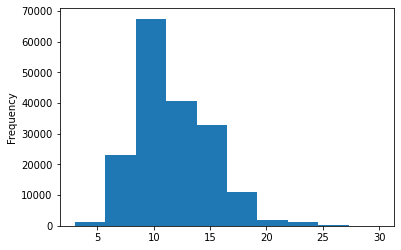

In [18]:
train_df['total lines'].plot.hist()

## Encoding Target

In [19]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)
train_target_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_target_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_target_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_target_label = label_encoder.fit_transform(train_df['target'].to_numpy())
val_target_label = label_encoder.fit_transform(val_df['target'].to_numpy())
test_target_label = label_encoder.fit_transform(test_df['target'].to_numpy())

In [21]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

## Model 0 : Baseline MultiNomimalNB

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("classifier",MultinomialNB())
  ]
)
model_0.fit(train_sentences,train_target_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [23]:
model_0.score(val_sentences,val_target_label)

0.7218323844829869

In [24]:
baseline_preds = model_0.predict(val_sentences)

In [25]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(baseline_preds,val_target_label)

0.7218323844829869

In [27]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-25 04:38:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-25 04:38:58 (81.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results

In [29]:
baseline_results = calculate_results(val_target_label,baseline_preds)

In [30]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

In [31]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as layers

In [32]:
sentences_lengths = [len(sentence.split()) for sentence in train_sentences]

In [33]:
sentences_lengths[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [34]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [35]:
print(np.mean(sentences_lengths))

26.338269273494777


(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

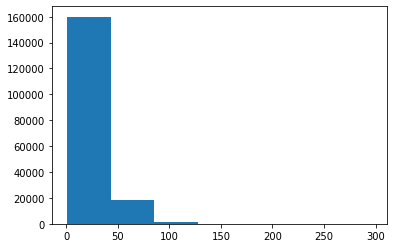

In [36]:
import matplotlib.pyplot as plt
plt.hist(sentences_lengths,bins = 7)

In [37]:
np.percentile(sentences_lengths,95)

55.0

In [38]:
max(sentences_lengths)

296

### Create Text Vectorizer Layer

In [39]:
max_tokens = 68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = 55
)

In [40]:
text_vectorizer.adapt(train_sentences)

In [41]:
import random
target_sentence = random.choice(train_sentences)
print("Text:",target_sentence)
print("Length of Text:",len(target_sentence))
print("Vectorizer Text:",text_vectorizer([target_sentence]))

Text: the results from this trial will inform evidence-based recommendations for suture selection in the management of patients undergoing total hip or knee replacement .
Length of Text: 164
Vectorizer Text: tf.Tensor(
[[   2  117   27   23   32   95 1945 1439 1421   11 1875 2171    5    2
   287    4   12  295   76  962   16  517 1075    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [42]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print("Most common words:",rct_20k_text_vocab[:5])

Most common words: ['', '[UNK]', 'the', 'and', 'of']


In [43]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Custom Token Embeddings

In [44]:
token_embeddings = tf.keras.layers.Embedding(
    input_dim = len(rct_20k_text_vocab),output_dim = 256,
    mask_zero = True #Mask variable lengths
    )

In [45]:
token_embeddings

In [46]:
print("Text :",target_sentence)
print("Vectorized Text:",text_vectorizer([target_sentence]))
print("Embedded Text:",token_embeddings(text_vectorizer([target_sentence])))

Text : the results from this trial will inform evidence-based recommendations for suture selection in the management of patients undergoing total hip or knee replacement .
Vectorized Text: tf.Tensor(
[[   2  117   27   23   32   95 1945 1439 1421   11 1875 2171    5    2
   287    4   12  295   76  962   16  517 1075    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
Embedded Text: tf.Tensor(
[[[ 0.00440336  0.03133886  0.01863943 ...  0.0186074   0.01369865
    0.04321045]
  [-0.03041635 -0.03888296  0.04289505 ...  0.02605612 -0.01397767
   -0.03404849]
  [-0.02041695  0.03053768  0.04832667 ... -0.0055486   0.04728607
    0.00034217]
  ...
  [ 0.0373078   0.00236049  0.01423374 ...  0.01065904  0.04193659
   -0.010641  ]
  [ 0.0373078   0.00236049  0.01423374 ...  0.01065904  0.04193659
   -0.010641  ]
  [ 0.0373078   0.00236049  0.01423374 

### Creating datasets (Fast Loads)

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_target_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_target_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_target_one_hot))

In [48]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [49]:
train_data = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1 : Conv1D with token Embeddings

In [50]:
from tensorflow.keras import layers

In [51]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embed = token_embeddings(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding = "same",activation = "relu")(token_embed)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation  = "softmax",name = "output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs)
model_1.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [52]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           16599296  
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [53]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [54]:
history_1 = model_1.fit(train_data,
      steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    )

Epoch 1/3
562/562 [==============================] - 54s 75ms/step - loss: 0.8720 - accuracy: 0.6608 - val_loss: 0.6624 - val_accuracy: 0.7520
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6434 - accuracy: 0.7655 - val_loss: 0.6254 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6048 - accuracy: 0.7797 - val_loss: 0.5861 - val_accuracy: 0.7889


In [55]:
model_1.evaluate(val_data)

945/945 [==============================] - 4s 4ms/step - loss: 0.5852 - accuracy: 0.7908


[0.585168719291687, 0.7908446788787842]

In [56]:
model_1_preds_probs = model_1.predict(val_data)

945/945 [==============================] - 3s 3ms/step


In [57]:
model_1_preds_probs.shape

(30212, 5)

In [58]:
model_1_probs = tf.argmax(model_1_preds_probs,axis = 1)

In [59]:
model_1_results = calculate_results(model_1_probs,val_target_label)

In [60]:
model_1_results

{'accuracy': 79.08446974712035,
 'precision': 0.7956288532710644,
 'recall': 0.7908446974712035,
 'f1': 0.7926318541770576}

## Model 2: Feature Extraction with pretrained token embeddings

In [61]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable = False)

In [62]:
random_train_sentence = random.choice(train_sentences)

In [63]:
from tensorflow.keras import layers

inputs = layers.Input(shape = [],dtype = tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation = "relu")(x)
outputs = layers.Dense(5,activation = "softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)
model_2.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [64]:
history_2 = model_2.fit(train_data,steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    )

Epoch 1/3
562/562 [==============================] - 13s 16ms/step - loss: 0.9149 - accuracy: 0.6514 - val_loss: 0.7962 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7691 - accuracy: 0.7002 - val_loss: 0.7571 - val_accuracy: 0.7081
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7527 - accuracy: 0.7115 - val_loss: 0.7393 - val_accuracy: 0.7148


In [65]:
model_2_preds_probs = model_2.predict(val_data)

945/945 [==============================] - 11s 11ms/step


In [66]:
model_2_probs = tf.argmax(model_2_preds_probs,axis = 1)

In [67]:
model_2_results = calculate_results(model_2_probs,val_target_label)

In [68]:
model_2_results

{'accuracy': 71.4318813716404,
 'precision': 0.725401682917676,
 'recall': 0.714318813716404,
 'f1': 0.7172629308841378}

## Model 3: Conv1D with Character Embeddings

### Character-Level Tokenizer

In [69]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [70]:
def split_chars(text):
  return " ".join(list(text))

In [71]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [72]:
char_lens = [len(sentence) for sentence in train_sentences]
print(np.mean(char_lens))

149.3662574983337


In [73]:
output_seq_char_len = int(np.percentile(char_lens,95))

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

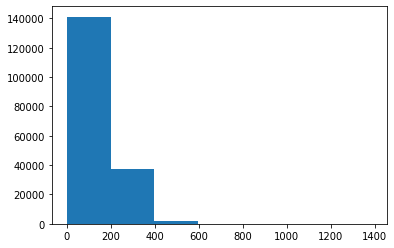

In [74]:
plt.hist(char_lens,bins = 7)

In [75]:
output_seq_char_len

290

In [76]:
import string
tokens = string.ascii_lowercase+string.digits+string.punctuation
tokens

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
num_char_tokens = len(tokens)+2
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
  output_sequence_length = output_seq_char_len,name = "char_vectorizer",
  standardize = "lower_and_strip_punctuation"
)

In [78]:
char_vectorizer.adapt(train_chars)

In [79]:
char_vocab = char_vectorizer.get_vocabulary()

In [80]:
print(len(char_vocab))

28


### Character-Level Embedding Layer

In [81]:
character_embeddings = layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    mask_zero = True,
    name = "char_embed"
    )

In [82]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
x = char_vectorizer(inputs)
x = character_embeddings(x)
x = layers.Conv1D(64,10,padding = "same",activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation = "softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)
model_3.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [83]:
history_3 = model_3.fit(train_data,steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    ) ## Reason of accuracy being low is that train_data is not optimized for character level model

Epoch 1/3
562/562 [==============================] - 14s 17ms/step - loss: 1.3619 - accuracy: 0.4302 - val_loss: 1.3306 - val_accuracy: 0.4338
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.3211 - accuracy: 0.4267 - val_loss: 1.3140 - val_accuracy: 0.4362
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 1.3120 - accuracy: 0.4368 - val_loss: 1.3155 - val_accuracy: 0.3939


### Tuning dataset for character level model

In [84]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
history_3 = model_3.fit(train_char_dataset,steps_per_epoch = int(0.1*len(train_char_dataset)),
      epochs = 3,
      validation_data = val_char_dataset,
      validation_steps = int(0.1*len(val_char_dataset))
    )

Epoch 1/3
562/562 [==============================] - 7s 12ms/step - loss: 1.2087 - accuracy: 0.5099 - val_loss: 1.0186 - val_accuracy: 0.5834
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.9658 - accuracy: 0.6128 - val_loss: 0.8893 - val_accuracy: 0.6549
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.8759 - accuracy: 0.6606 - val_loss: 0.8223 - val_accuracy: 0.6799


In [86]:
model_3_prob_preds = model_3.predict(val_char_dataset)

945/945 [==============================] - 3s 3ms/step


In [87]:
model_3_preds = tf.argmax(model_3_prob_preds,axis = 1)

In [88]:
model_3_results = calculate_results(model_3_preds,val_target_label)

In [89]:
model_3_results

{'accuracy': 67.45001985965841,
 'precision': 0.7007809476814895,
 'recall': 0.6745001985965842,
 'f1': 0.6810613928571806}

## Model 4: Combining pretrained token embeddings + characters embedding

### Token Model

In [90]:
token_inputs = layers.Input(shape = [],dtype = tf.string,name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(100,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,outputs = token_output)

### Character Model

In [91]:
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = character_embeddings(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # BI-LSTM
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

### Concatenate Token and Character Model

In [92]:
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output = layers.Dense(5,activation = "softmax")(final_dropout)
model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],outputs = output)

In [93]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]']      

In [94]:
model_4.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ['accuracy'])


In [95]:
from keras.utils import plot_model

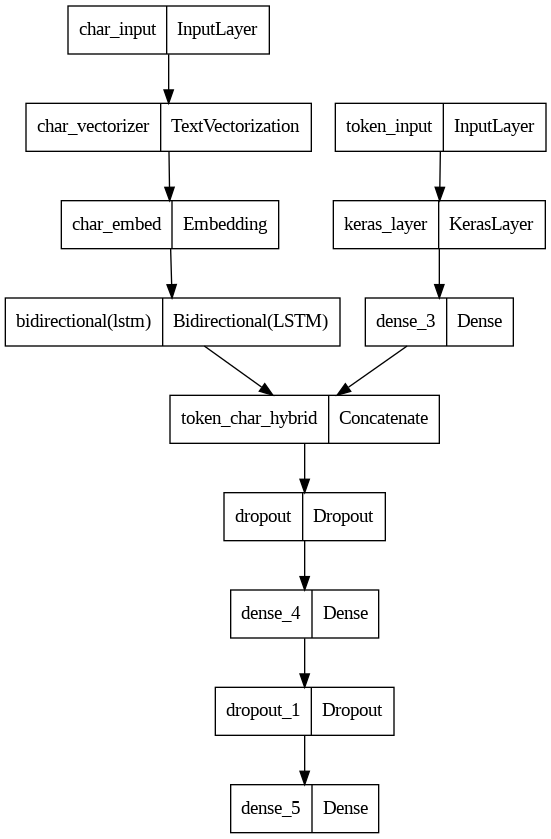

In [96]:
plot_model(model_4)

## Combining Character and Token Data into Dataset

In [97]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_label = tf.data.Dataset.from_tensor_slices((train_target_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [98]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_label = tf.data.Dataset.from_tensor_slices((val_target_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
history_4 = model_4.fit(train_token_char_dataset,steps_per_epoch = int(0.1*len(train_token_char_dataset)),
      epochs = 3,
      validation_data = val_token_char_dataset,
      validation_steps = int(0.1*len(val_token_char_dataset))
    )

Epoch 1/3
562/562 [==============================] - 49s 67ms/step - loss: 0.9992 - accuracy: 0.6008 - val_loss: 0.7921 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 41s 73ms/step - loss: 0.8092 - accuracy: 0.6864 - val_loss: 0.7257 - val_accuracy: 0.7251
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7862 - accuracy: 0.7008 - val_loss: 0.6959 - val_accuracy: 0.7360


In [100]:
model_4_prob_preds = model_4.predict(val_token_char_dataset)

945/945 [==============================] - 23s 21ms/step


In [101]:
model_4_preds = tf.argmax(model_4_prob_preds,axis = 1)

In [102]:
model_4_results = calculate_results(model_4_preds,val_target_label)

In [103]:
model_4_results

{'accuracy': 73.60651396795976,
 'precision': 0.7438675620229328,
 'recall': 0.7360651396795975,
 'f1': 0.7384799496345591}

## Model 5: Pre-Trained Model with Character, Token and Positional Embeddings

**Note: Feature Engineered attributes should be available during test time as well. In this case line numbers and total_lines**

### Positional Embeddings

In [104]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

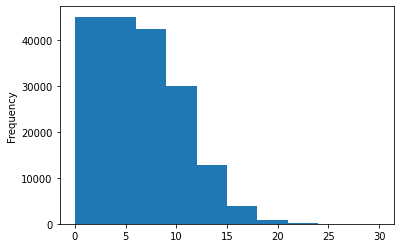

In [113]:
train_df.line_number.plot.hist()

In [149]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth = 15)

<Axes: ylabel='Frequency'>

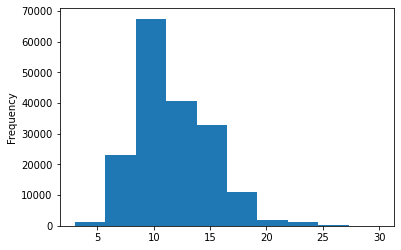

In [115]:
train_df['total lines'].plot.hist()

In [148]:
train_total_line_one_hot = tf.one_hot(train_df['total lines'].to_numpy(),depth = 20)
val_total_line_one_hot = tf.one_hot(val_df['total lines'].to_numpy(),depth = 20)
test_total_line_one_hot = tf.one_hot(test_df['total lines'].to_numpy(),depth = 20)

### Building a tribrid embedding model


In [176]:
token_inputs = layers.Input(shape = [],dtype = tf.string,name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,outputs = token_output)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = character_embeddings(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape = (15,),dtype = tf.float32,name = "line_number_input")
line_number_output = layers.Dense(32,activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_output)

total_lines_inputs = layers.Input(shape = (20,),dtype = tf.float32,name = "total_lines_input")
total_lines_output = layers.Dense(32,activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_output)

### Combining Token and Char Models (Hybrid Embedding)

In [177]:
token_char_embeddings = layers.Concatenate(name = "char_token_hybrid")([
    token_model.output,char_model.output
])
x = layers.Dense(256,activation = "relu")(token_char_embeddings)
x = layers.Dropout(0.5)(x)


### Combining Positional embeddings with hybrid embeddings

In [178]:
x = layers.Concatenate()([
    line_number_model.output,
    total_lines_model.output,
    x])
output_layer = layers.Dense(5,activation = "softmax",name = "output_layer")(x)
model_5 = tf.keras.Model(inputs = [
    line_number_model.input,
    total_lines_model.input,
    token_model.input,
    char_model.input
],outputs = output_layer)

In [179]:
model_5.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]']     

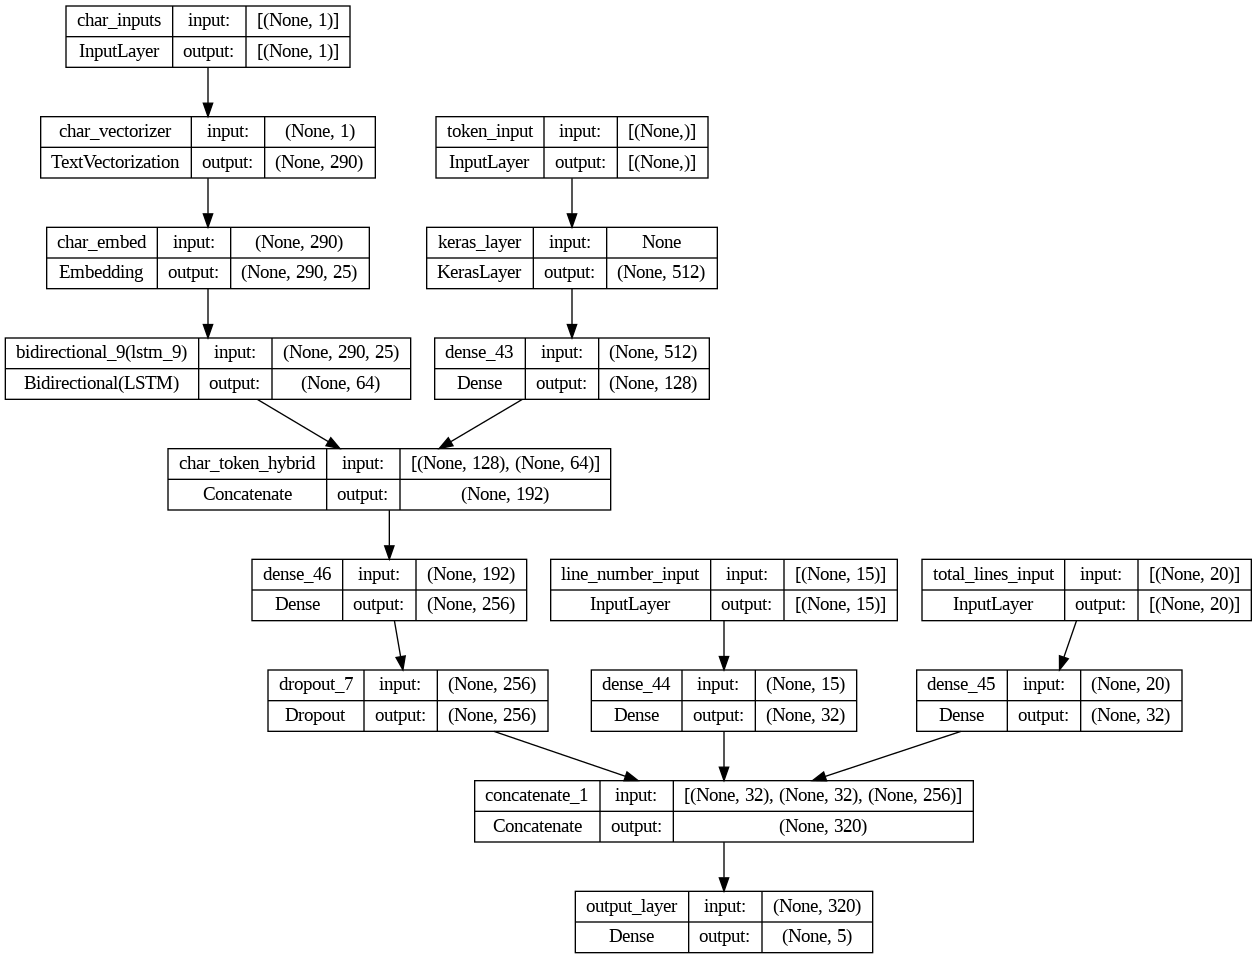

In [180]:
plot_model(model_5,show_shapes = True)

In [181]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),optimizer = "adam",metrics = ['accuracy'])

In [182]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,train_total_line_one_hot,train_sentences,train_chars
))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_target_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [183]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,val_total_line_one_hot,val_sentences,val_chars
))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_target_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [184]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((
    test_line_numbers_one_hot,test_total_line_one_hot,test_sentences,test_chars
))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_target_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [185]:
history_5 = model_5.fit(train_char_token_pos_dataset,epochs = 3,
                        steps_per_epoch = int(0.1*(len(train_char_token_pos_dataset))),
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(0.1*(len(val_char_token_pos_dataset)))
                        )

Epoch 1/3
562/562 [==============================] - 60s 89ms/step - loss: 1.1005 - accuracy: 0.7209 - val_loss: 0.9834 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9671 - accuracy: 0.8177 - val_loss: 0.9499 - val_accuracy: 0.8298
Epoch 3/3
562/562 [==============================] - 36s 64ms/step - loss: 0.9508 - accuracy: 0.8227 - val_loss: 0.9394 - val_accuracy: 0.8351


In [189]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose = 1)
model_5_preds = tf.argmax(model_5_pred_probs,axis = 1)


945/945 [==============================] - 22s 20ms/step


In [190]:
model_5_results = calculate_results(y_true = val_target_label,y_pred = model_5_preds)

## Comparing Model Results

In [191]:
all_model_results = pd.DataFrame({
    "model_0_baseline":baseline_results,
    "model_1_custom_token_embedding":model_1_results,
    "model_2_pretrained_token_embedding":model_2_results,
    "model_3_character_embedding":model_3_results,
    "model_4_hybrid":model_4_results,
    "model_5_tribrid":model_5_results,
})

In [192]:
all_model_results = all_model_results.transpose()

In [193]:
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,79.084470,0.795629,0.790845,0.792632
model_2_pretrained_token_embedding,71.431881,0.725402,0.714319,0.717263
model_3_character_embedding,67.450020,0.700781,0.674500,0.681061
model_4_hybrid,73.606514,0.743868,0.736065,0.738480
model_5_tribrid,83.506554,0.834460,0.835066,0.833914


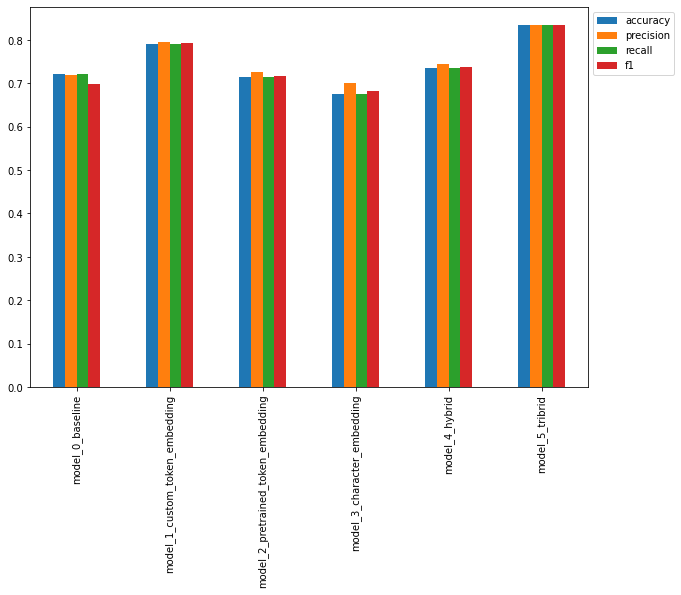

In [197]:
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results.plot(kind = "bar",figsize = (10,7)).legend(bbox_to_anchor= (1.0,1.0))

## Save and Load Model

In [198]:
model_5.save("skimlit_tribrid_model")

In [199]:
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [201]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)

945/945 [==============================] - 32s 27ms/step


In [202]:
loaded_preds = tf.argmax(loaded_pred_probs,axis = 1)

In [204]:
loaded_model_results = calculate_results(y_true = val_target_label,y_pred = model_5_preds)

In [205]:
loaded_model_results

{'accuracy': 83.50655368727658,
 'precision': 0.8344595829789448,
 'recall': 0.8350655368727657,
 'f1': 0.8339135184454768}